# Zooming in on particular Grand datasets 

We use GLoVE vectors, they have worked best so far.

# Global data, set to run notebook

Expected locations of data:
* Grand ratings and features: "Grand_etal_csv", subdirectory of current directory
* Glove: "glove", subdirectory of current directory

In [6]:
glove_path = "glove/glove.42B.300d.zip"
glove_file = "glove.42B.300d.txt"

grandratings_dir = "Grand_etal_csv/"
grandfeatures_path = "Grand_etal_csv/features.xlsx"

# The Grand category and feature to be illustrated

In [7]:
# grand_category = "clothing"
# grand_feature = "wealth"

# randomseed = 3
# how_many_pieces = 3
# testfold = 0

grand_category = "animals"
grand_feature = "size"

randomseed = 3
how_many_pieces = 3
testfold = 0

# Reading data

In [8]:
import os
from scipy import stats
import numpy as np 
import pandas as pd
import zipfile
import math
import sklearn
import torch
import torch.optim as optim
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
import matplotlib.pyplot as plt

In [9]:
# GLoVE vectors


feature_dim = 300

word_vectors = { }

with zipfile.ZipFile(glove_path) as azip:
    with azip.open(glove_file) as f:
        for line in f:
            values = line.split()
            word = values[0].decode()
            vector = np.array(values[1:], dtype=np.float32)
            word_vectors[word] = vector

In [10]:


grandfeatures_df = pd.read_excel(grandfeatures_path)

/Users/kee252/Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [11]:
filename = grandratings_dir + grand_category + "_" + grand_feature + ".csv"

df = pd.read_csv(filename)
nspeakers = len(df.columns) -1
df["Average"] = [row.iloc[1:26].sum() / nspeakers for _, row in df.iterrows()]
# z-scores of average ratings
df["Gold"] = (df["Average"] - df["Average"].mean()) / df["Average"].std()

# obtain seed words from excel file
relevant_row = grandfeatures_df[grandfeatures_df.Dimension == grand_feature]
seedwords = relevant_row.iloc[:, 1:].values.flatten().tolist()
pos_seedwords = seedwords[:3]
neg_seedwords = seedwords[3:]

print(df.sort_values(by="Gold")[["Row", "Gold"]].head())
print(df.sort_values(by="Gold")[["Row", "Gold"]].tail())

          Row      Gold
21   mosquito -1.290254
2         bee -1.210256
1         ant -1.208326
4   butterfly -1.072907
22      mouse -1.028466
         Row      Gold
26     rhino  1.441055
23      orca  1.648460
18   mammoth  1.692424
13  elephant  1.782467
33     whale  2.091105


In [12]:
print("Pos seeds", pos_seedwords)
print("Neg seeds", neg_seedwords)

Pos seeds ['large', 'big', 'huge']
Neg seeds ['small', 'little', 'tiny']


# Train/test split



In [13]:


# split into training and test

rng = np.random.default_rng(seed = randomseed)
fold = rng.integers(low = 0, high = how_many_pieces, size = len(df.Gold))

test_indices =  [i for i in range(len(df.Gold)) if fold[i] == testfold]
print("Test datapoints")
for _, ell in df.iloc[ test_indices].iterrows():
    print("\t", ell["Row"], ell["Gold"])

Test datapoints
	 ant -1.208326308336452
	 bee -1.2102556044209594
	 bird -0.8410833918441782
	 butterfly -1.0729067060469573
	 chipmunk -0.9219349516600045
	 crow -0.5924394424967795
	 dog -0.13772507741655235
	 goldfish -1.0137086641794912
	 hamster -1.0107162658006708
	 mammoth 1.6924235867922455
	 monkey -0.011646655884267072
	 seal 0.28524877814483307
	 whale 2.091104770822308


# Obtaining predictions

Train on train, predict on all, store results in the dataframe for seed-based and fit+s models.

In [14]:
# obtaining predictions for each datapoint
import eval_dim
import compute_dim
import statistics

# compute training and test data.
# we got test indices above
train_indices = [i for i in range(len(df.Gold)) if fold[i] != testfold]
all_thisdata_vectors = [word_vectors[ row.Row ] for row in df.itertuples() ]
gold_train = [ ell["Gold"] for _, ell in df.iloc[ train_indices ].iterrows()]
words_test =  [ell["Row"] for _, ell in df.iloc[ test_indices].iterrows()]
words_train = [ell["Row"] for _, ell in df.iloc[ train_indices].iterrows()]
vec_test =  [word_vectors[ w ] for w in words_test]
vec_train = [word_vectors[ w ] for w in words_train ]

random_seed = 123
hyper_offset = 1.0
hyper_jitter = False
hyper_average = True
hyper_alpha_s = 0.05

# seed-based dimension
seed_dimension = compute_dim.dimension_seedbased(pos_seedwords, neg_seedwords, word_vectors)
# df["Seed"] = compute_dim.predict_coord_fromtrain(vec_train, gold_train, dimension, all_thisdata_vectors)
df["Seed"] = compute_dim.predict_coord_fromtrain(all_thisdata_vectors, df.Gold, seed_dimension, all_thisdata_vectors)

# df["Seed"] = compute_dim.predict_scalarproj(all_thisdata_vectors, dimension)

# fit+s dimension
fit_dimension, fit_weight, fit_bias = compute_dim.dimension_fitted_fromratings_combined(vec_train, gold_train,
                                                                    300,
                                                                    pos_seedwords, neg_seedwords, word_vectors,
                                                                    offset = hyper_offset, 
                                                                    alpha = hyper_alpha_s,
                                                                    random_seed = random_seed)
df["Fit+s"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, fit_dimension, fit_weight, fit_bias)

In [15]:
testdf = df.iloc[ test_indices].copy()

# Ranking the datapoints, in comparison

In [16]:
# rankings of the datapoints
gold_wordrank = list(testdf.sort_values(by = "Gold").Row)
seed_wordrank = list(testdf.sort_values(by = "Seed").Row)
fits_wordrank = list(testdf.sort_values(by = "Fit+s").Row)

In [17]:
print("Rankings: Gold, Seed, Fit+s\n")
for i, word in enumerate(gold_wordrank):
    print(word,  "&", seed_wordrank[i], "&", fits_wordrank[i], '\\\\')

Rankings: Gold, Seed, Fit+s

bee & chipmunk & butterfly \\
ant & hamster & bee \\
butterfly & monkey & chipmunk \\
goldfish & butterfly & bird \\
hamster & goldfish & hamster \\
chipmunk & dog & ant \\
bird & bee & crow \\
crow & bird & goldfish \\
dog & seal & seal \\
monkey & crow & dog \\
seal & ant & monkey \\
mammoth & whale & whale \\
whale & mammoth & mammoth \\


In [18]:
# sort by square error
print("Datapoints, sorted by square error")
for column in ["Seed", "Fit+s"]:
    sqerr = (testdf.Gold - testdf[column])**2

    print(column)
    for se, word in sorted(zip(sqerr, testdf.Row)):
        print(word, se)
        
    print()

Datapoints, sorted by square error
Seed
ant 0.583459411239141
whale 3.0524416671954238
crow 3.6585423553692173
bee 5.411137753245342
bird 6.3351700191229545
seal 10.055810026875577
dog 11.703481578568605
goldfish 21.387100572293974
butterfly 26.25037472401858
monkey 44.96134081920683
hamster 74.06697282421638
chipmunk 86.88600680669717
mammoth 183.88949570085092

Fit+s
bird 7.242353577719127e-06
monkey 0.0002134560976268735
chipmunk 0.0034060004209440684
dog 0.00850228028459677
crow 0.016746849734129692
butterfly 0.02607609399953525
mammoth 0.03320735336347038
hamster 0.051126271718089186
goldfish 0.09020705800756221
bee 0.09272376689891007
ant 0.23267297083073998
seal 0.7206765082973732
whale 1.7116529740972126



In [19]:
# sort datapoints by error in rank
print("Datapoints, by error in rank")
for column in ["Seed", "Fit+s"]:
    print(column, "\n")
    goldrank  = testdf.Gold.rank()
    modelrank = testdf[column].rank()
    sqdiff = (goldrank - modelrank)**2
    for sd, word in sorted(zip(sqdiff, testdf.Row)):
        print(word, sd)
    
    

Datapoints, by error in rank
Seed 

bird 1.0
butterfly 1.0
goldfish 1.0
mammoth 1.0
whale 1.0
crow 4.0
seal 4.0
dog 9.0
hamster 9.0
chipmunk 25.0
bee 36.0
monkey 49.0
ant 81.0
Fit+s 

hamster 0.0
bee 1.0
crow 1.0
dog 1.0
mammoth 1.0
monkey 1.0
whale 1.0
butterfly 4.0
seal 4.0
bird 9.0
chipmunk 9.0
ant 16.0
goldfish 16.0


# Plotting test vectors and interpretable dimensions in a 2-d image


In [20]:
# projection of a vector along a direction,
# where we want the actual vector, not its length
# (vec * direction1) * direction1
def vector_projection(vec, direction):
    dir_veclen = math.sqrt(np.dot(direction, direction))
    direction1 = direction / dir_veclen
    return np.dot(vec, direction1) * direction1

In [21]:

###
# Code for projecting embeddings down to 2-d
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

###
# function that produces a visualization of a given list of words.
# parameters
# - words: list of words to visualize
# - seeds_pos, seeds_neg: seedwords, which will also be visualized
# - space: dictionary mapping words to numpy arrays that are embeddings
# - lines: information about lines to add to the picture. This is a Python dictionary;
#   - key 'wordpairs': list of pairs of words: add lines between those words
#   - key 'dims': list of vectors that represent averaged interpretable dimensions.
#     For each dimension, project two words onto it, and draw a line through those two points
#   - key 'pointpairs': list of pairs of vectors: project into 2d space and draw a line through them
#   - key "colors": list of colors for the lines, one per line, first for word pairs lines,
#          then dims lines, then pointpairs lines
def visualize(words, seeds_pos, seeds_neg, space, lines, omitwords = []):
    # make the scatter plot
    allwords, twodim, pca_obj = plot_points(words, seeds_pos, seeds_neg, space, omitwords = omitwords)
    
    lineindex = 0
    
    # for every pair of words for which we want to draw
    # an individual-wordpair line: draw the line
    if "wordpairs" in lines:
        for word1, word2 in lines["wordpairs"]:
            i1 = allwords.index(word1)
            point1 = twodim[i1]
            i2 = allwords.index(word2)
            point2 = twodim[i2]
        
            if "colors" in lines:
                plt.axline(point1, point2, c=lines["colors"][lineindex])
            else:
                plt.axline(point1, point2)
                
            lineindex += 1
        
    # for every vector that is an averaged dimension:
    # project two words onto this vector to get two points, 
    # then draw a line through those two points.
    if "dims" in lines:
        for avgvector in lines["dims"]:
            # project the first two words onto the average vector
            # where we need the actual vector, not just its length
            proj1 = vector_projection(space[ words[0] ], avgvector)
            proj2 = vector_projection(space[ words[1] ], avgvector)
        
            # make them into an array to feed into pca
            x = np.array( [ proj1, proj2])
        
            # downproject to two dimensions
            points = pca_obj.transform(x)[:,:2]
        
            # and plot the line
            if "colors" in lines:
                plt.axline( points[0], points[1], c=lines["colors"][lineindex])
            else:
                plt.axline( points[0], points[1])
                
            lineindex += 1
            
    if "pointpairs" in lines: 
        for vec1, vec2 in lines["pointpairs"]:
            # downproject the two points
            x = np.array( [vec1, vec2 ])
            points = pca_obj.transform(x)[:, :2]
            
            # and plot
            if "colors" in lines:
                plt.axline( points[0], points[1], c = lines["colors"][lineindex])
            else:
                plt.axline(points[0], points[1])
                
            lineindex += 1
                
    plt.show()
        
    
def plot_points(words, seeds_pos, seeds_neg, space, omitwords = [ ]):
    allwords = words + seeds_pos + seeds_neg
    
    # put all the word vectors into one matrix
    word_vectors = np.array([space[w] for w in allwords])
    
    # use dimensionality reduction: 
    # Principal Component Analysis, PCA
    # keep the two first dimensions
    pca_obj = PCA()
    twodim = pca_obj.fit_transform(word_vectors)[:,:2]

    # set up the canvas
    plt.figure(figsize=(6,6))
    
    # plot colors: blue for concept words, 
    # green for positive seeds, red for negative seeds
    plotcolors = [ ]
    for w in allwords:
        if w in seeds_pos: plotcolors.append("g")
        elif w in seeds_neg: plotcolors.append("r")
        else: plotcolors.append("b")
    
    # add a scatter plot of the two-D embeddings
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', 
                c=plotcolors)

    # add each of the words to the plot, a bit above and to the right
    # of the 2-D dot it goes with
    for word, (x,y) in zip(allwords, twodim):
        if word not in omitwords:
            plt.text(x+0.05, y+0.05, word)

    return (allwords, twodim, pca_obj)
    # now show the canvas
    # plt.show()
    


### Seed-based dimension only

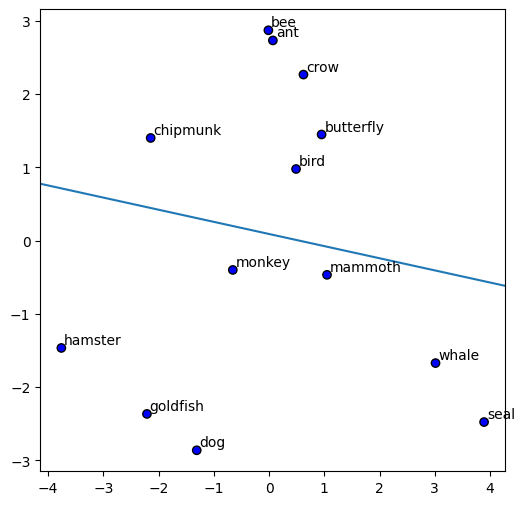

In [22]:
visualize(list(testdf["Row"]), [], [], word_vectors,  
          {"dims" : [seed_dimension]}, omitwords = ["sweatshirt", "belt", "hat"])

### Seed-based and fitted dimension

blue: seed based

red: fitted.

In [ ]:
visualize(list(testdf["Row"]), [], [], word_vectors,  
          {"dims" : [seed_dimension], 
           "pointpairs" : [ (np.zeros(feature_dim), fit_dimension)],
          "colors" : ["b", "r"]}, 
          omitwords = ["sweatshirt", "belt", "hat"])

# Illustrating residuals

In [ ]:
testdf.sort_values(by="Gold", inplace = True)

In [ ]:
offset= []
nextoffset = 0
for  _, ell in df.iloc[ test_indices].iterrows():
    offset.append(nextoffset)
    nextoffset += 2 * len(ell["Row"]) + 2
    
testdf["Offset"] = offset
    
testdf.plot(kind = "scatter", y= ["Gold", "Seed", "Fit+s"], x = ["Offset", "Offset", "Offset"], 
            c = [0, 0.7, 0.3]*len(testdf.Gold), colormap = "rainbow", ylabel = "Rating", xlabel = "", xticks = [])